# Introduction to Synthetic Aperture Radar Using Python and MATLAB 

## by Andy Harrison - © 2022 Artech House

---

## Example 3.4.6 Polar Format Algorithm - Learjet

---

**Import Modules**

In [1]:
%matplotlib inline

import numpy as np

from scipy.constants import speed_of_light, pi

from scipy.io import loadmat

from scipy.interpolate import griddata

from matplotlib import pyplot as plt

import warnings

**Load the selected signature file**

In [2]:
signature = loadmat('lear_0el_90az.mat')

**Select the polarization**

In [3]:
signal = np.squeeze(signature['vv'])

**Get the frequency**

In [4]:
frequency = np.squeeze(signature['frequency'])

**Get the azimuth angles**

In [5]:
az = np.squeeze(signature['az'])

**Get the elevation angle**

In [6]:
el = np.squeeze(signature['el'])

**Set the image span (m)**

In [7]:
x_span = 30

y_span = 30

**Set the number of bins in the image**

In [8]:
nx = 1000 # Number of bins in x-direction

ny = 1000 # Number of bins in y-direction

**Set the synthetic aperture azimuth span (deg)**

In [9]:
az_start = 88

az_end = 92

**Set the image dynamic range (dB)**

In [10]:
dynamic_range = 35 

**Choose the pulses in the azimuth range**

In [11]:
sensor_az = []

index = []

i = 0

# Loop over all azimuth angles
for a in az:
    
    if az_start <= a and a <= az_end:
        
        sensor_az.append(a)
        
        index.append(i)
        
        i += 1

**Rotate for polar format**

In [12]:
sensor_az = sensor_az - 90 * np.ones_like(sensor_az)

signal1 = np.squeeze(signal[:, index, 66])

sensor_el = np.radians(el[66]) * np.ones_like(sensor_az)

**Get the data size**

In [13]:
nf = frequency.shape

na = sensor_az.shape

**Calculate the signal in wavenumber space**

In [14]:
# Initialize the signal and k-space

kx = np.zeros_like(signal1)

ky = np.zeros_like(signal1)

kc = 2 * pi * frequency / speed_of_light


# Short hand and helps with computational load

ca = np.cos(np.radians(sensor_az))

sa = np.sin(np.radians(sensor_az))


# Loop over all azimuth angles
i = 0

for c, s in zip(ca, sa):
    
    kx[:, i] = kc * c
    
    ky[:, i] = kc * s
        
    i += 1

**Plot the signal in wavenumber space**

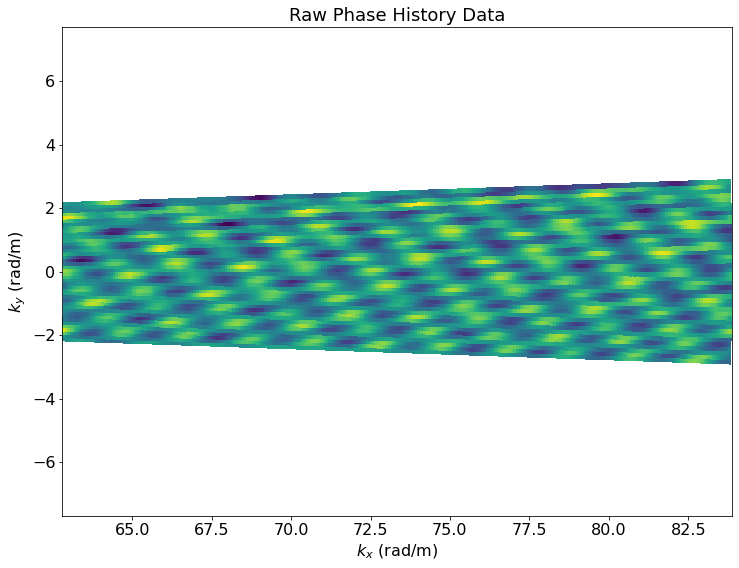

In [15]:
# Ignore warning about irregular data

warnings.filterwarnings('ignore')



# Set the figure size

plt.rcParams["figure.figsize"] = (12, 9)



# Plot the raw phase history data
plt.figure

plt.pcolor(kx, ky, signal1.real)



# Set the plot title and labels

plt.title('Raw Phase History Data', size=18)

plt.xlabel('$k_x$ (rad/m)', size=16)

plt.ylabel('$k_y$ (rad/m)', size=16)



# Set the tick label size

plt.tick_params(labelsize=16)



# Makes axes equal

plt.axis('equal')

# plt.gca().set_aspect('equal', adjustable='box')



# Show the figure

plt.show()

**Set up the wavenumber space regular grid**

In [16]:
kxmin = np.min(kx)

kxmax = np.max(kx)


kymin = np.min(ky)

kymax = np.max(ky)


kxp = np.linspace(kxmin, kxmax, 400)

kyp = np.linspace(kymin, kymax, 400)


kxp, kyp = np.meshgrid(kxp, kyp)

**Perform the interpolation**

In [17]:
# griddata somewhat limited
new_signal = griddata((kx.ravel(), ky.ravel()), signal1.ravel(), (kxp, kyp), method='linear', fill_value=0)

**Plot the reformatted phase history data**

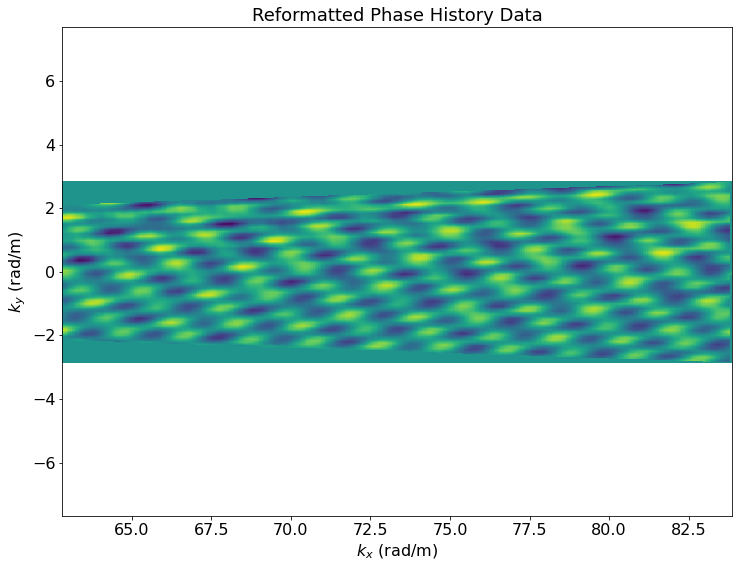

In [18]:
plt.figure

plt.pcolor(kxp, kyp, new_signal.real)



# Set the plot title and labels

plt.title('Reformatted Phase History Data', size=18)

plt.xlabel('$k_x$ (rad/m)', size=16)

plt.ylabel('$k_y$ (rad/m)', size=16) 



# Set the tick label size

plt.tick_params(labelsize=16)



# Make the axes equal

plt.axis('equal')

# plt.gca().set_aspect('equal', adjustable='box')



# Show the figure

plt.show()

**Calculate the frequency step size (Hz)**

In [19]:
frequency_step = speed_of_light / (2 * pi) * (kxp[0,1] - kxp[0,0])

**Calculate the maximum scene size and resolution (m)**

In [20]:
range_extent = speed_of_light / (2 * frequency_step)

**Calculate the range window for the pulses (m)**

In [21]:
range_window = np.linspace(-0.5 * range_extent, 0.5 * range_extent, int(nx))

**Calculate the frequency step size (Hz)**

In [22]:
frequency_step = speed_of_light / (2 * pi) * (kyp[1,0] - kyp[0,0])

**Calculate the maximum scene size and resolution (m)**

In [23]:
cross_range_extent = speed_of_light / (2 * frequency_step)

**Calculate the range window for the pulses (m)**

In [24]:
cross_range_window = np.linspace(-0.5 * cross_range_extent, 0.5 * cross_range_extent, int(ny))

**Calculate the range compressed signal**

In [25]:
r_signal = np.fft.fftshift(np.fft.ifft(new_signal, nx, axis=1),1)

**Calculate the formatted ky wavenuber**

In [26]:
kypp = np.linspace(np.min(ky), np.max(ky), 400)

**Calculate the focused image**

In [27]:
ra_signal = np.fft.fftshift(np.fft.ifft(r_signal, ny, axis=0), 0)

**Plot the range compressed data**

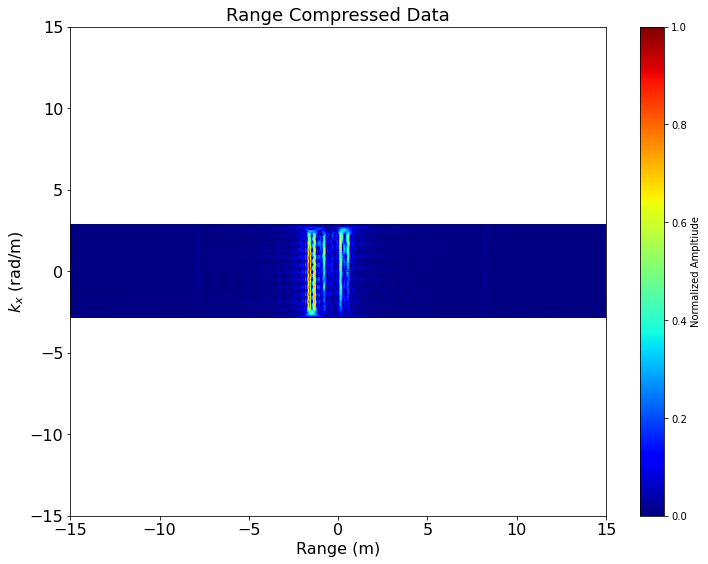

In [28]:
# Plot the range compressed data

plt.figure

plt.pcolor(range_window, kypp, np.abs(r_signal)/np.max(np.abs(r_signal)), cmap='jet')



# Set the limits for the x- and y-axis

plt.xlim(-0.5 * x_span, 0.5 * x_span)

plt.ylim([-0.5 * y_span, 0.5 * y_span])



# Set the title and labels

plt.title('Range Compressed Data', size=18)

plt.xlabel('Range (m)', size=16)

plt.ylabel('$k_x$ (rad/m)', size=16)



# Set the tick label size

plt.tick_params(labelsize=16)



# Make the axes equal

# plt.axis('equal')



# Turn on the colorbar and set the label

cbar = plt.colorbar()

cbar.set_label('Normalized Ampltiude')



# Show the figure

plt.show()

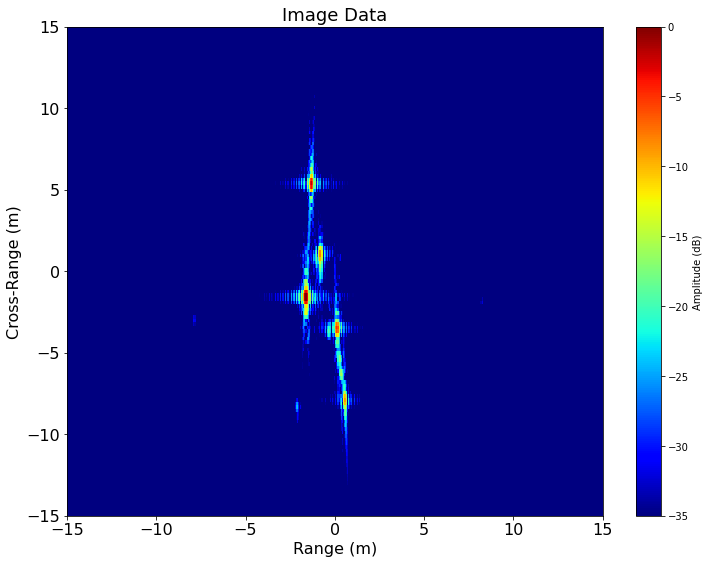

In [29]:
# Plot the focused image
plt.figure 

plt.pcolor(range_window, cross_range_window, 20 * np.log10(np.abs(ra_signal)/np.max(np.abs(ra_signal))), cmap='jet', vmin=-abs(dynamic_range), vmax=0)

plt.xlim([-0.5 * x_span, 0.5 * x_span])

plt.ylim([-0.5 * y_span, 0.5 * y_span])



# Set the title and labels

plt.title('Image Data', size=18)

plt.xlabel('Range (m)', size=16)

plt.ylabel('Cross-Range (m)', size=16)



# Set the tick label size

plt.tick_params(labelsize=16)



# Make the axes equal

# plt.axis('equal')

# plt.gca().set_aspect('equal', adjustable='box')



# Turn on the colorbar and set the label

cbar = plt.colorbar()

cbar.set_label('Amplitude (dB)')



# Show the figure

plt.show()